(2000, 2856, 3)
(2000, 2856, 3)


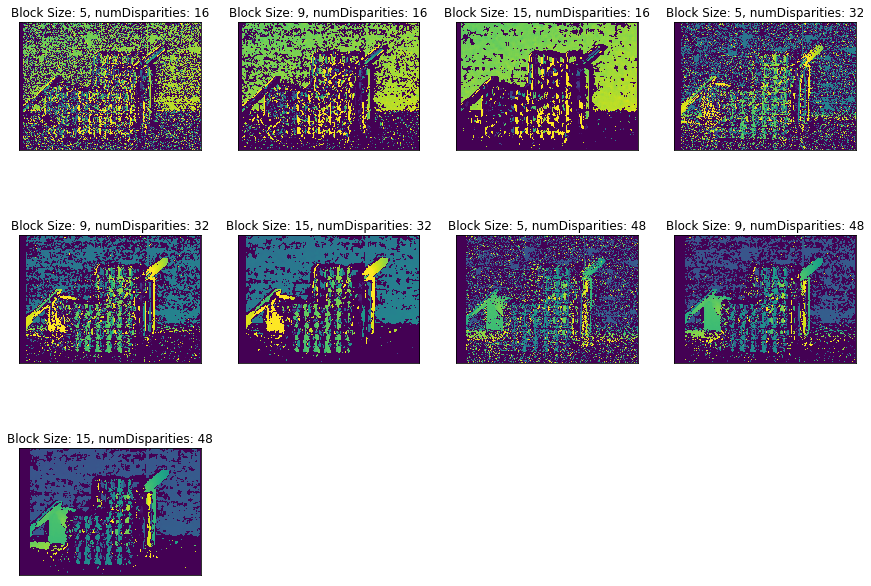

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# load left and right images
imgL = cv2.imread("im0_stereo.png")
imgR = cv2.imread("im1_stereo.png")
print(imgL.shape)
print(imgR.shape)


# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)


block_size = [5, 9, 15]
num_disparities = [16, 32, 48]
params = []
disparity_list = []
for disp in num_disparities:
    for block in block_size:
        params.append((block, disp))
        stereo = cv2.StereoBM_create(numDisparities=disp, blockSize=block)
        disparity = stereo.compute(imgL_gray, imgR_gray)
        disparity_list.append(disparity)
        
row = 4
col = 4
plt.figure(figsize=(15, 15))
for i in range(0, 9):
    plt.subplot(row, col, i+1), plt.imshow(disparity_list[i])
    plt.title('Block Size: {}, numDisparities: {}'.format(params[i][0], params[i][1])), plt.xticks([]), plt.yticks([])
plt.show()

In [35]:
import sys
import re
from struct import *
import numpy as np
from matplotlib import pyplot as plt

def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
    return img

(2000, 2856)


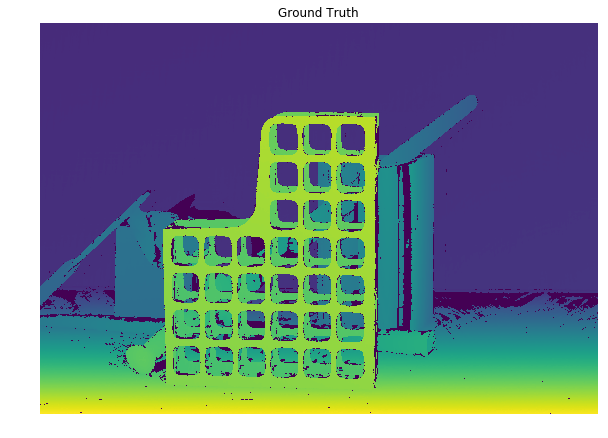

Min MSE:  21632.37  at index:  0


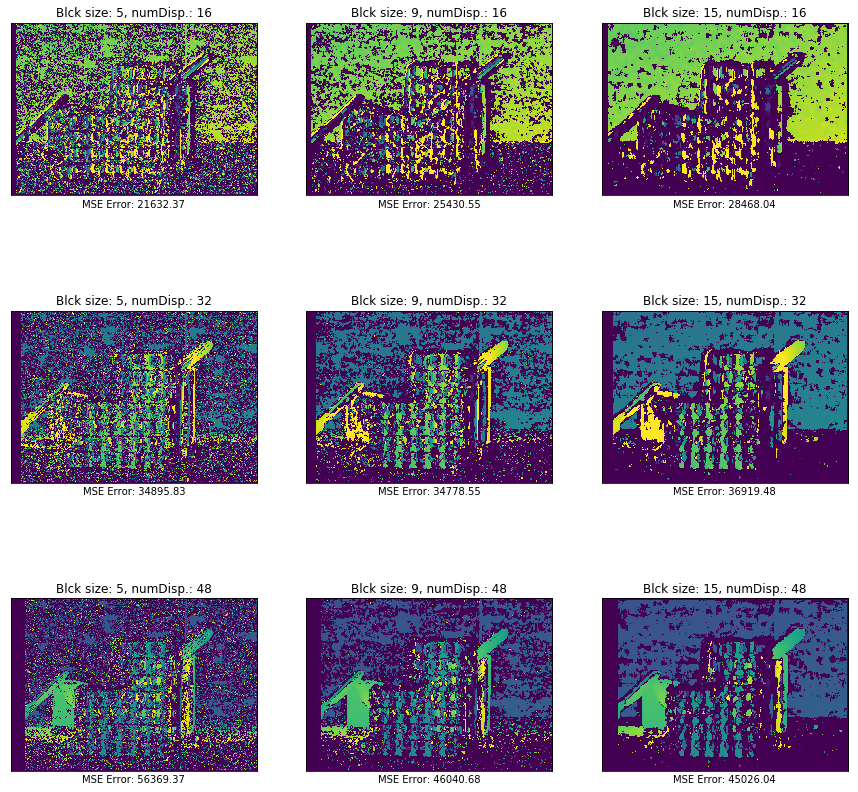

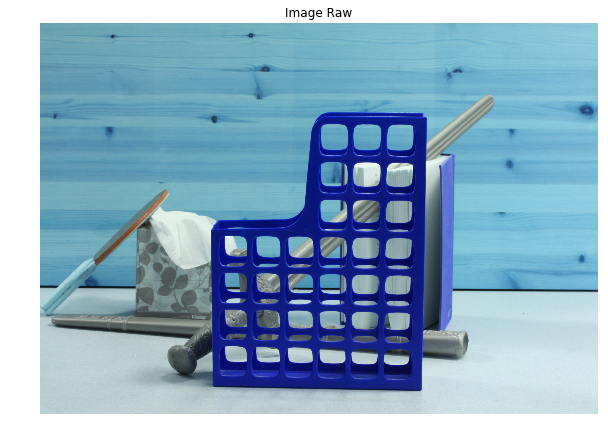

In [54]:
ground_truth = read_pfm("disp1.pfm")
print(ground_truth.shape)

# Ground truth has some bad values so we set them to zero
ground_truth[ground_truth==np.inf] = 0
plt.figure(figsize=(10,10)), plt.imshow(ground_truth)

plt.title("Ground Truth"), plt.axis("off"), plt.show()

# Resize ground truth to match computed disparity maps
ground_truth = cv2.resize(ground_truth, None, fx=0.3, fy=0.3)

error_imgs = []
error_vals = []


for disp in disparity_list:
    error_img = (cv2.subtract(ground_truth, disp.astype(np.float64)))**2
    error_val = (error_img).mean(axis=None)
    error_vals.append(round(error_val, 2))

min_val = min(error_vals)
print("Min MSE: ", min_val, " at index: ", error_vals.index(min_val))

row = 3
col = 3
plt.figure(figsize=(15, 15))
for i in range(0, 9):
    plt.subplot(row, col, i+1), plt.imshow(disparity_list[i])
    plt.title('Blck size: {}, numDisp.: {}'.format(params[i][0], params[i][1])), plt.xticks([]), plt.yticks([])
    plt.xlabel("MSE Error: {}".format(error_vals[i]))
plt.show()


imgL = cv2.imread("im0_stereo.png")
plt.figure(figsize=(10,10)), plt.imshow(imgL)
plt.title("Image Raw"), plt.axis("off")
plt.show()

#### Comment on the error-maps for each combination of parameters. Specifically, mention the effects of varying the parameters on the error in the region of high/low texture, edge, large/small depths.

In regards to texture, increasing the disparity leads to an increase in accuracy for areas of low texture and decreases accuracy in areas of high texture. In regards to the blocksize, increasing block size in general, decreases acccuracy for areas of high texture and smaller blocksizes work for areas with low texture areas. 

In regards to edges, increasing the number of disparities seems to increase the overall definition of the edges. This can be seen by the fact that in our high disparity images the outline of the black object is completely missing meaning it was matched very well. Increasing blocksize however reduces the appearance of edges that are thin. Thinner lines will tend to potentially be drowned out in larger blocksizes are less prominent. 

In regards to the depths. Increasing number of disparities helps to improve overall detection of depth however increasing block size increases the consistency of estimations and ensures that maps look less noisy.